<a href="https://colab.research.google.com/github/EugenioBugli/PointCloud3D/blob/main/PointCloud3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [253]:
%%capture
!pip install --upgrade pip
!pip install -q open3d
!pip install -q torch_scatter
!pip install ninja
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
!pip install trimesh
!pip install trimesh[easy]
# !pip install pyfqmr
# !pip install .
!git clone https://github.com/EugenioBugli/PointCloud3D.git

In [254]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.auto import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt
from torch_scatter import scatter_mean, scatter_max

import open3d as o3d
import plotly.graph_objects as go

from pytorch3d.loss import chamfer_distance
from scipy.spatial import cKDTree
import trimesh
# import pyfqmr
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

import sys
sys.path.insert(0,'/content/PointCloud3D')
from PointCloud3D.Src.dataset import FAUST_Dataset, LoadDataset, openDataFiles, SaveDataset
from PointCloud3D.Src.utils import Plot2D, voxel2Numpy, PlotVoxel, Plot2DWithBuckets, PlotOccupancyMesh, o3d2Trimesh, toPointCloud, Cloud2Voxel
from PointCloud3D.Src.unet import UNet

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

from google.colab import drive
drive.mount("/content/drive")

drive_path = "/content/drive/MyDrive/CV/MPI-FAUST"
training_path = drive_path + "/training"
test_path = drive_path + "/test"

Using PyTorch version: 2.5.1+cu121  Device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [255]:
SAMPLING_TYPE = "RANDOM"
SAMPLING_SIZE = 2048
BATCH_SIZE = 5

IN_DIM_RES_PT = 64
FEATURES_DIM = 32
NUM_BLOCKS = 5
NUM_FC = 4
NUM_PLANES = 4
NUM_COORDINATES = 3

# 1] Dataset


In [256]:
# use this to create the dataset

# train_scan_files, train_reg_files, val_scan_files, val_reg_files, test_scan_files, test_reg_files = openDataFiles(training_path, test_path, val_size=0.2)
# train_set = FAUST_Dataset(train_scan_files, train_reg_files, sampling_size=SAMPLING_SIZE, partition="TRAIN", transform=transforms.ToTensor())
# val_set = FAUST_Dataset(val_scan_files, val_reg_files, sampling_size=SAMPLING_SIZE, partition="VAL", transform=transforms.ToTensor())
# test_set = FAUST_Dataset(test_scan_files, test_reg_files, sampling_size=SAMPLING_SIZE, partition="TEST", transform=transforms.ToTensor())

# SaveDataset(train_set, "train_set.pt")
# SaveDataset(val_set, "val_set.pt")
# SaveDataset(test_set, "test_set.pt")

In [257]:
train_set = LoadDataset("train_set.pt")
val_set = LoadDataset("val_set.pt")
test_set = LoadDataset("test_set.pt")

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=1)
test_loader = DataLoader(dataset=test_set, batch_size=1)

# 1.2] Visualization

In [ ]:
for batch in train_loader:
    sampled_scan = batch[0]
    registration = batch[1]
    query = batch[2]
    scan_path = batch[3]
    reg_path = batch[4]
    print(sampled_scan.shape, registration.shape, query.shape)
    print(len(scan_path), len(reg_path))
    break

torch.Size([5, 3000, 3]) torch.Size([5, 6890, 3]) torch.Size([5, 2048, 3])
5 5


# 2] Encoder

## 2.1) ResBlock + Functions

In [258]:
class ResBlock(nn.Module):
    """
        This class is used to define a Residual Block, which is one of the main component of the ResNetPointNet architecture
    """

    def __init__(self, in_dim=64, n_points=2048, h_dim=32, out_dim=64):
        super(ResBlock, self).__init__()

        self.n_points = n_points

        #> First part of the Block

        self.fc1 = nn.Linear(
            in_dim,
            h_dim
        )
        self.bn1 = nn.BatchNorm1d(self.n_points)

        #> Second part of the Block

        self.fc2 = nn.Linear(
            h_dim,
            out_dim
        )
        self.bn2 = nn.BatchNorm1d(self.n_points)

        #> Skip connection

        if in_dim != out_dim:
            # size mismatch (never happen in my case)
            self.residual = nn.Linear(in_dim, out_dim)
        else:
            # same size
            self.residual = None


    def forward(self, x):
        # Input: (b,p,in_dim) = (b,p,64)

        first_part = F.relu(self.bn1(self.fc1(x))) # (b,p,64) -> (b,p,32)

        second_part = self.bn2(self.fc2(first_part)) # (b,p,32) -> (b,p,64)

        if self.residual is None:
            # no size mismatch
            res = x # (b,p,64)
        else:
            # transformation if there is a size mismatch in_dim != out_dim
            res = self.residual(x) # (b,p,in_dim) -> (b,p,64)

        # add residual connection
        third_part = second_part + res # (b,p,64) -> (b,p,64)

        return F.relu(third_part)

## 2.2) ResNetPointNet

In [259]:
def CloudNormalization(input_cloud):
    # normalize cloud in order to have it in [0,1]
    min = input_cloud.min()
    max = input_cloud.max()
    norm_cloud = (input_cloud - min)/(max-min)
    return norm_cloud

def CanonicalProjection(input_cloud):
    # gives you a dict with all 3 canonical projections (xy, xz, yz)
    xy_proj = CloudNormalization(input_cloud[:,:,[0,1]]) # XY plane (view from above)
    xz_proj = CloudNormalization(input_cloud[:,:,[0,2]]) # XZ plane (view from long side)
    yz_proj = CloudNormalization(input_cloud[:,:,[1,2]]) # YZ plane (view from short side)
    return {"xy": xy_proj, "xz": xz_proj, "yz": yz_proj}

def DivideInBuckets(input_cloud_proj, resolution):
    # in input we have the canonical projection of the input cloud and the resolution of our buckets
    # map 2D coordinates into one dimension
    with torch.no_grad():
        xy_buck = (input_cloud_proj["xy"]*resolution).clamp(0, resolution-1).long()
        xz_buck = (input_cloud_proj["xz"]*resolution).clamp(0, resolution-1).long()
        yz_buck = (input_cloud_proj["yz"]*resolution).clamp(0, resolution-1).long()
    return {"xy": xy_buck[:,:,0] + resolution*xy_buck[:,:,1], "xz": xz_buck[:,:,0] + resolution*xz_buck[:,:,1], "yz": yz_buck[:,:,0] + resolution*yz_buck[:,:,1]}

def LocalMaxPooling(input_features, input_cloud, resolution):
    # given the 3D point cloud I need to project them into a 2D grid. In this way I can define the neighborhood to perform local pooling
    # voxelization is not a good idea since I will lose details (all points are averaged into a voxel)
    canon_proj = CanonicalProjection(input_cloud)
    # we need to divide this 2D planes into buckets and the perform inside each of them the pooling operation
    indices = DivideInBuckets(canon_proj, resolution) # only the full buckets are taken from the resolution^2 buckets
    pooled_dict = dict()
    gathered_container = None
    for plane in canon_proj.keys():
        projection_indices = indices[plane]
        scatter_container = []
        # max pooling operation over the input_features (batch, num_points, 32)
        for batch in range(input_cloud.shape[0]):
            features = input_features[batch]
            per_batch_indices = projection_indices[batch]
            # print(f"min indices: {per_batch_indices.min().item()}, max indices: {per_batch_indices.max().item()}, res^2: {resolution**2}")
            scatter_batch, _ = scatter_max(features, per_batch_indices.detach(), dim=0, dim_size=resolution**2)
            scatter_container.append(scatter_batch)

        scatter_container = torch.stack(scatter_container, dim=0) # (batch_size, resolution**2, features_dim)
        pooled_dict[plane] = scatter_container
        # perform the gathering operation over the max point of each plane
        with torch.no_grad():
            projection_indices_clamp = projection_indices.clamp(0, resolution**2-1).detach()
        gathered = scatter_container.gather(dim=1, index=projection_indices_clamp.unsqueeze(-1).expand(input_cloud.shape[0], input_cloud.shape[1], scatter_container.size(-1)).contiguous())
        if gathered_container is None:
            gathered_container = gathered
        else:
            gathered_container = gathered_container + gathered
    return gathered_container # (batch_size, num_points, features_dim)

In [260]:
class ResNetPointNet(nn.Module):
    """
        This class is used to define the PointNet model used to form a feature embedding for each point in the Point Cloud given in input.
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3)

            > Fully Connected Layer (3, in_dim=64)
            > 5 Residual Blocks with Local Pooling and Concatenation
            > Fully Connected Layer (out_dim=32, out_dim=32)

            @ OUTPUT: Tensor of shape (batch_size, num_points, 32)
    """

    def __init__(self, in_dim=64, n_points=2048, res_dim=32, out_dim=32, n_blocks=5):
        super(ResNetPointNet, self).__init__()

        self.fc1 = nn.Linear(3, in_dim)

        self.res = nn.ModuleList([
            ResBlock(in_dim, n_points, res_dim, out_dim) for n_res in range(n_blocks)
        ])

        self.fc2 = nn.Linear(out_dim, out_dim)

    def forward(self, x):
        # Input: (b,p,3)

        # Extract Normalized coordinates and indices to perform local pooling

        norm_coord = CanonicalProjection(x) # (b,p,2)
        coord_indices = DivideInBuckets(norm_coord, 32) # (b,p,2)

        # First FC Layer
        fc1 = F.relu(self.fc1(x)) # (b,p,3) -> (b,p,64)
        #print("fc1: ",fc1.shape)
        # First ResBlock
        res = self.res[0](fc1) # (b,p,64) -> (b,p,32)
        #print("res: ",res.shape)
        # 2-5 ResBlock
        for res_block in self.res[1:]:
            pool = LocalMaxPooling(res, x, 32) # (b,p,32)
            #print("pool: ",pool.shape)
            concat = torch.cat([res, pool], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)
            #print("concatenation: ",concat.shape)
            # following residual block
            res = res_block(concat) # (b,p,64) -> (b,p,32)

        # Last FC Layer
        final = F.relu(self.fc2(res)) # (b,p,32) -> (b,p,32)

        #   print(f"ResNetPointNet : input ({x.shape}) ---> output ({final.shape}) \n")

        return final

## 2.3) Plane Predictor

In [261]:
class SimplePointNet(nn.Module):
    """
        This class is used to define a simple variant of the PointNet Model, which is one of the main components of the Plane Predictor Network.
        This Network will provide us a global context of the Input Point Clouds
        Architecture Design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent the Input Point Clouds

            > Fully Connected Layer (3, 64)

              |> Fully Connected Layer (64, 32)
            2*|> Global Max Pooling
              |> Concatenation btw Pooled and unpooled features

            > Fully Connected Layer (64, 32)
            > Global Max Pooling

            @ OUTPUT: Tensor of shape (batch_size, 1, 32) which will be used by the rest of the Plane Predictor
    """

    def __init__(self, in_dim=64, n_points=2048, hid_dim=32, out_dim=64):
        super(SimplePointNet, self).__init__()

        self.n_points = n_points

        self.initial_fc = nn.Linear(in_features=3, out_features=in_dim)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.fc2 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.final_fc = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

    def forward(self, x):
        batch_size = x.shape[0]
        x = F.relu(self.initial_fc(x)) # (b,p,3) --> (b,p,64)

        x1 = F.relu(self.fc1(x)) # (b,p,64) --> (b,p,32)
        x1_t = x1.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x1 = self.pool(x1_t) # (b,32,p) -> (b,32,1)
        exp_pool_x1 = pool_x1.transpose(1,2).expand(batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x1 = torch.cat([x1, exp_pool_x1], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        x2 = F.relu(self.fc2(concat_x1)) # (b,p,64) -> (b,p,32)
        x2_t = x2.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x2 = self.pool(x2_t) # (b,32,p) -> (b,32,1)
        exp_pool_x2 = pool_x2.transpose(1,2).expand(batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x2 = torch.cat([x2, exp_pool_x2], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        pre_pool_out = F.relu(self.final_fc(concat_x2)) # (b,p,64) -> (b,p,32)
        pre_pool_out_t = pre_pool_out.transpose(1,2) # (b,p,32) -> (b,32,p)
        out = self.pool(pre_pool_out_t) # (b,32,p) -> (b,32,1)

        # print(f"SimplePointNet : input ({x.shape}) ---> output ({out.transpose(1,2).shape}) \n")
        return out.transpose(1,2) # (b,32,1) -> (b,1,32)

In [262]:
class PlanePredictor(nn.Module):
    """
        This class is used to define the Plane Predictor of our Architecture, which will predict the plane parameters of L dynamic planes
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent Point Clouds

            > Simple PointNet which learns the global context of the input point clouds
            > This information is encoded into one global feature by using Max Pooling
            > 4 Fully Connected Layers with hidden dimension = 32
            > Transform this features with a shallow net (from 32 to L dim) (plane parameters)
            > Refine each plane parameter with a Shallow net
            > Get plane features (from L to 32 dim)
            > Each plane-specific feature is expanded to N x D to match the output of the point cloud encoder, which will be summed together


            @ OUTPUT: Tensor of shape (batch_size, num_points, 32) which will be summed up to the features given by the ResNetPointNet before
                      being processed into U-Net and the plane parameter tensor (batch_size, L, 3)

    """
    def __init__(self, in_dim=32, n_points=2048, n_fc=4, L=4):
        super(PlanePredictor, self).__init__()

        self.pointNet = SimplePointNet(in_dim=IN_DIM_RES_PT, n_points=n_points, hid_dim=in_dim, out_dim=IN_DIM_RES_PT)
        self.n_points = n_points
        self.L = L

        self.four_fc = nn.ModuleList(
            [nn.Linear(in_dim, in_dim) for i in range(n_fc)]
        )
        # want L plane parameters
        self.feat_to_plane = nn.Linear(in_dim, 3*self.L)

        self.L_shallows = nn.ModuleList(
            [nn.Linear(3, 3) for i in range(self.L)]
        )

        # L FC layers with hidden dim = 32

        self.L_plane_to_features = nn.ModuleList(
            [nn.Linear(3, in_dim) for i in range(self.L)]
        )

    def forward(self, x):

        flc = self.pointNet(x) # (b,p,3) -> (b,1,32) # features from simplepointnet

        for fc in self.four_fc: # 4 fully connected block
            flc = F.relu(fc(flc))  # (b,1,32) -> (b,1,32)

        plane_param = F.relu(self.feat_to_plane(flc)) # (b,1,32) -> (b,1,3*L)
        plane_param = plane_param.view(plane_param.shape[0], self.L, 3) # (b,1,3*L) -> (b,L,3)

        stack_of_planes = []
        features = 0
        for p in range(self.L):
            # I need to refine the plane parameters by passing them into a separate shallow net
            pth_plane = F.relu(self.L_shallows[p](plane_param[:,p,:])) # (b,3) -> (b,3)
            stack_of_planes.append(pth_plane)

            pth_feat = F.relu(self.L_plane_to_features[p](pth_plane)) # (b,3) -> (b,32)
            features = features + pth_feat.unsqueeze(1)

        out_features = features.expand(x.shape[0], self.n_points, pth_feat.shape[-1]) # (b,L,32) -> (b,p,32)
        stack_of_planes = torch.stack(stack_of_planes, dim=1)
        # print(f"PlanePredictor : input ({x.shape}) ---> output ({out_features.shape}, {stack_of_planes.shape}) \n")
        return out_features, stack_of_planes

## 2.4) Feature Projection Process

$R = I + skew(v) + skew(v)^2 \cdot \frac{1-\mathcal{k} \cdot \mathcal{\hat{n}}} {||v||^2}$

In [263]:
# we need to project the encoded features (the output of the previous step aka 2.2+2.3) onto the dynamic planes with a defined size of H x W grid and then
# apply max-pooling for the features inside each cell
# 3 different operations must be employed to keep them inside H x W grids.
# > Basis Change
# > Orthographic Projection aka project the summed-up features onto the dynamic planes
# > Normalization
# > apply local max pooling to each bucket (H*W buckets)

def skew_symm(v):
    if len(v.shape) == 2: return torch.tensor([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]]).to(device)
    else: # if you pass a batch of vectors
        sk = torch.zeros((v.shape[0], 3, 3)).to(device)
        for j in range(v.shape[0]):
            sk[j] = skew_symm(v[j])
        return sk

def dot_prod(v1, v2): # assume that you always pass 2 vect with same dimension (2D or 3D)
    if len(v1.shape) == 2:
        return torch.bmm(v1.unsqueeze(2), v2.unsqueeze(1))
    return torch.bmm(v1.transpose(1,2),v2)


# Given the vectors, of the 3 canonical axes, (i,j,k) and the learned plane normal n we need to perform a change of basis:
# First we transform n into a unit vector n_hat
# We compute the rotation matrix that aligns k (basic vector of the ground plane) and n_hat by following the equation displayed above

def ChangeOfBasis(n): # n is the learned plane normal (what you get from the plane predictor net) (batch_size, 3, 1)
    # reorientation of the coordinate system to align it with the dynamic plane
    batch_size, num_planes, num_points = n.shape
    n = n.reshape(batch_size*num_planes, 3).unsqueeze(2) # (b,L,3,1)->(b*L,3,1)
    n = n.to(device)
    # these unit vectors need a shape (batch_size*L, 3, 1)
    i = torch.tensor([1.,0.,0.], device=device).repeat(n.shape[0], 1).unsqueeze(2)
    j = torch.tensor([0.,1.,0.], device=device).repeat(n.shape[0], 1).unsqueeze(2)
    k = torch.tensor([0.,0.,1.], device=device).repeat(n.shape[0], 1).unsqueeze(2)

    n_hat = n/torch.norm(n)
    v = skew_symm(k) @ n_hat# cross product btw k and n_hat
    R = torch.eye(3).to(device).unsqueeze(0).repeat(n.shape[0], 1, 1) + skew_symm(v) + skew_symm(v).matmul(skew_symm(v))*(1 - dot_prod(k,n_hat))/(torch.norm(v)**2)
    # this rotation matrix is applied to i and j

    i_p = R @ i
    j_p = R @ j

    if torch.norm(i_p) != 1 : i_p = i_p/torch.norm(i_p)
    if torch.norm(j_p) != 1 : j_p = j_p/torch.norm(j_p)

    # return i_p, j_p
    return i_p.reshape(batch_size, num_planes, 3, 1), j_p.reshape(batch_size, num_planes, 3, 1)

def OrthographicProjection(p, i_p, j_p, MISE=False): # probably has more sense to simply use R
    # p is the set of points that must be projected while i_p and j_p are the axes of the plane
    batch_size, num_planes, _, _ = i_p.shape
    num_points = p.shape[1]

    if len(i_p.shape) > 3: # assume that both i_p and j_p have the same size
        i_p = i_p.view(batch_size*num_planes, i_p.shape[2], 1)
        j_p = j_p.view(batch_size*num_planes, j_p.shape[2], 1)

    if MISE:
        p = p.unsqueeze(1).repeat(1, num_planes, 1, 1) # (k,p,3) -> (k,L,p,3)
        p_planes = p.view(p.shape[0]*num_planes, num_points, 3) # (k,L,p,3) -> (k*L,p,3)
        # from (1,L,3,1) to (k,L,3,1)
        i_p = i_p.repeat(p.shape[0], 1, 1, 1)
        j_p = j_p.repeat(p.shape[0], 1, 1, 1)
        # from (k,L,3,1) to (k*L,3,1)
        i_p = i_p.view(p.shape[0]*num_planes, j_p.shape[2], 1)
        j_p = j_p.view(p.shape[0]*num_planes, j_p.shape[2], 1)

        x_p = torch.bmm(p_planes, i_p)
        y_p = torch.bmm(p_planes, j_p)
        return torch.stack([x_p, y_p], dim=2).view(p.shape[0], num_planes, num_points, 2).to(device) # (k,L,p,2)

    if len(p.shape) < 4:
        p = p.unsqueeze(1).repeat(1, num_planes, 1, 1) # (b,p,3) -> (b,L,p,3)
        p = p.view(batch_size*num_planes, p.shape[2], 3) # (b,L,p,3) -> (b*L,p,3)

    x_p = torch.bmm(p, i_p)
    y_p = torch.bmm(p, j_p)

    return torch.stack([x_p, y_p], dim=2).view(batch_size, num_planes, num_points, 2).to(device)

def ComputeNormConst(i_p, j_p): # use this to compute directly the normalization constant c >= 1

    i_p_abs = torch.abs(i_p.view(i_p.shape[0]*i_p.shape[1], i_p.shape[2], 1))
    j_p_abs = torch.abs(j_p.view(j_p.shape[0]*j_p.shape[1], j_p.shape[2], 1))

    ones = torch.ones((i_p_abs.shape[0], 1, 3)).to(device)

    a_i = torch.bmm(ones, i_p_abs)/(torch.bmm(i_p_abs.transpose(2,1),i_p_abs)) * i_p_abs
    a_j = torch.bmm(ones, j_p_abs)/(torch.bmm(j_p_abs.transpose(2,1),j_p_abs)) * j_p_abs

    c = torch.max(torch.norm(a_i, dim=1), torch.norm(a_j, dim=1))
    c = torch.clamp(c, min=1.0) # must be >= 1
    return c # (b*L, 1, 1)

# Move everything into a grid

def FeatureProjection(input_cloud, plane_features, plane_param, H=64, W=64):
    # plane_features, plane_parame are the output of the plane predictor net
    i_p, j_p = ChangeOfBasis(plane_param) # both are (b,L,3,1)
    projected_plane = OrthographicProjection(input_cloud, i_p, j_p) # (b,L,p,2)
    c = ComputeNormConst(i_p, j_p) #(b*L,1)
    # normalization
    norm_plane = projected_plane.view(c.shape[0], projected_plane.shape[2], 2)/c.unsqueeze(1) # (b*L,p,2)

    # now we need to perform pooling inside each bucket of a grid H*W
    with torch.no_grad():
        x_norm = (norm_plane[:,:,0]*W).long().clamp(0,W-1)
        y_norm = (norm_plane[:,:,1]*H).long().clamp(0,H-1)
        indices = x_norm + W*y_norm# .view(BATCH_SIZE, NUM_PLANES, input_cloud.shape[1])# (b,L,p)

    out_scatter, _ = scatter_max(plane_features.reshape(plane_param.shape[0]*plane_param.shape[1], input_cloud.shape[1], -1).contiguous(), indices, dim=1, dim_size=H*W)

    return out_scatter.view(plane_param.shape[0]*plane_param.shape[1], H, W, -1)

## 2.5) Complete Encoder Architecture

In [264]:
class Encoder(nn.Module):

    def __init__(self, in_dim=64, out_dim=32, n_points=2048, n_blocks=5, num_planes=NUM_PLANES, num_fc=4):
        super(Encoder, self).__init__()

        self.resnet_pointnet = ResNetPointNet(in_dim=in_dim, n_points=n_points, out_dim=out_dim, n_blocks=n_blocks).to(device)
        self.plane_predictor = PlanePredictor(in_dim=out_dim, n_points=n_points, n_fc=num_fc, L=num_planes).to(device)
        self.UNet = UNet(in_dim=out_dim, out_dim=out_dim, features_dim=in_dim, n_points=n_points).to(device)


    def forward(self, x):
        feat_resnet = self.resnet_pointnet(x)
        feat_plane, plane_param = self.plane_predictor(x)
        summed_up_feat = (feat_resnet + feat_plane).unsqueeze(1).repeat(1, NUM_PLANES, 1, 1) # (b,p,32) -> (b,L,p,32)
        # here we need to perform features projection

        feat_proj = FeatureProjection(x, summed_up_feat, plane_param) # returns the projection of the features and the projected and norm plane
        out_unet = self.UNet(feat_proj.permute(0,-1,1,2)) # need (b*L,32,H,W) instead of (b*L,H,W,32)
        return out_unet, plane_param

# 3] Decoder

In [265]:
# After the Unet, I have L dynamic planes each with feature map H*W of dimension 32 for each batch
# Before using the real decoder network I need to follows these steps:
# > we need to project any point of a cloud onto all dynamic planes
# > use bilinear interpolation of the feature encoded at the four neighboring plane grids (smooth)
# > concatenate the L features obtained
# > obtain occupancy prediction from the decoder
class Decoder(nn.Module):
    """
        This class is used to define the Decoder Network. The architecture is composed by 5 ResNet blocks with hidden dimension 32 followed by a small
        Fully Connected netowrk that returns the Occupancy prediction.
        Given the features vector in input, we have to perform Bilinear Interpolation before the ResNet blocks.
        Architecture design:

            @ INPUT:
                > Tensor of shape [features vector] (batch_size, num_points, features=32*L)


            @ OUTPUT:
                > Tensor of shape [occupancy prediction] (batch_size, n_points=2048, 1)
    """

    def __init__(self, in_dim=32*NUM_PLANES, n_points=2048, n_blocks=5):
        super(Decoder, self).__init__()

        self.res_blocks = nn.ModuleList(
            [ResBlock(in_dim, n_points, in_dim, in_dim) for i in range(n_blocks)]
        )
        self.occupancy_pred = nn.Sequential(
            nn.Linear(in_dim, in_dim//2),
            nn.ReLU(),
            nn.Linear(in_dim//2, 1),
            nn.Sigmoid(), # choose if you directly apply bce with logits or not
        )

    def forward(self, x):

        for res_block in self.res_blocks:
            x = res_block(x) # check if the addition of the feature vector is correct

        occupancy = self.occupancy_pred(x)
        # print(f"Decoder : ({x.shape}) --> ({occupancy.shape}) \n")

        return occupancy

# 4] Network

In [266]:
# I use as input a noisy point cloud (point cloud + sampled noise with zero mean and stdev 0.05)
# Uniformly sampled cloud is used as the occupancy supervision aka my label -> use this to found the real occupancy value !
# Training with BCE
# Inference -> Multiresolution Isosurface Extraction used to construct meshes starting from the occupancy grid
class CompleteArchitecture(nn.Module):

    def __init__(self, in_dim=64, out_dim=32, n_points_encoder=3000, n_points_decoder=2048, n_blocks=5, num_planes=4, num_fc=4):
        super(CompleteArchitecture, self).__init__()
        self.encoder = Encoder(n_points=n_points_encoder) # 3000 points from a noisy cloud given in input to learn the features
        self.decoder = Decoder(n_points=n_points_decoder) # 2048 points sampled uniformly (both inside and outside the cloud)

        # this parameters will be used later during MISE
        self.enc_features = None
        self.i_p = None
        self.j_p = None
        self.c = None
        self.plane_param = None

    def forward(self, noisy_cloud, sampled_cloud):
        batch_size, num_points_noisy, _ = noisy_cloud.shape
        num_points_sampled = sampled_cloud.shape[1]

        out_enc, plane_param = self.encoder(noisy_cloud)
        # need to perform the projection of the sampled_cloud into the dynamic planes
        num_planes = plane_param.shape[1]
        i_p, j_p = ChangeOfBasis(plane_param)
        proj_plane = OrthographicProjection(sampled_cloud, i_p, j_p) # (B,L,p,2)
        c = ComputeNormConst(i_p, j_p) #(b*L,1)
        norm_plane = proj_plane.view(c.shape[0], proj_plane.shape[2], 2)/c.unsqueeze(1) # (b*L,p,2)

        norm_plane = 2.0 * norm_plane - 1.0 # from [0,1] to [-1,1]
        #print(norm_plane.shape)

        interpol_feat = F.grid_sample(out_enc, norm_plane.unsqueeze(1), mode='bilinear', align_corners=True)
        #print(interpol_feat.shape)
        interpol_feat = interpol_feat.squeeze(2).permute(0,2,1).view(batch_size, num_planes, sampled_cloud.shape[1], interpol_feat.shape[1])
        #print(interpol_feat.shape)
        concat_feat = interpol_feat.reshape(batch_size, -1, num_planes*interpol_feat.shape[-1])
        occupancy = self.decoder(concat_feat)
        return occupancy

    def getEncoderFeatures(self, noisy_cloud): # compute only one time during MISE
        out_enc, plane_param = self.encoder(noisy_cloud)
        i_p, j_p = ChangeOfBasis(plane_param)
        c = ComputeNormConst(i_p, j_p)
        self.enc_features = out_enc
        self.plane_param = plane_param
        self.i_p = i_p
        self.j_p = j_p
        self.c = c

    def forward_MISE(self, chunk):
        proj_plane = OrthographicProjection(chunk, self.i_p, self.j_p, MISE=True) # (B,L,p,2)
        # print(self.c.shape)
        # print(f"proj: {proj_plane.shape}, {proj_plane.view(proj_plane.shape[0]*proj_plane.shape[1], proj_plane.shape[2], 2).shape}")
        # print(f"c: {self.c.shape}, unsq {self.c.unsqueeze(1).shape}")
        # print(f"c.rep: {self.c.unsqueeze(0).repeat(proj_plane.shape[0],1,1).shape}, c.rep.view: {self.c.unsqueeze(0).repeat(proj_plane.shape[0],1,1).view(proj_plane.shape[0]*proj_plane.shape[1],1).shape}")
        # print(f"c.rep.view.unsq: {self.c.unsqueeze(0).repeat(proj_plane.shape[0],1,1).view(proj_plane.shape[0]*proj_plane.shape[1],1).unsqueeze(1).shape}")
        c = self.c.unsqueeze(0).repeat(proj_plane.shape[0],1,1).view(proj_plane.shape[0]*proj_plane.shape[1],1)
        norm_plane = proj_plane.view(proj_plane.shape[0]*proj_plane.shape[1], proj_plane.shape[2], 2)/c.unsqueeze(1) # (b*L,p,2)
        norm_plane = 2.0 * norm_plane - 1.0 # from [0,1] to [-1,1]
        # print(f"enc start: {self.enc_features.shape}")
        # print(f"enc later: {self.enc_features.unsqueeze(0).repeat(proj_plane.shape[0],1,1,1,1).shape}")
        # print(f"norm: {norm_plane.unsqueeze(1).shape}")
        feat = self.enc_features.unsqueeze(0).repeat(proj_plane.shape[0],1,1,1,1).view(proj_plane.shape[0]*proj_plane.shape[1],self.enc_features.shape[1],self.enc_features.shape[2],self.enc_features.shape[3])
        interpol_feat = F.grid_sample(feat, norm_plane.unsqueeze(1), mode='bilinear', align_corners=True)
        interpol_feat = interpol_feat.squeeze(2).permute(0,2,1).view(proj_plane.shape[0], proj_plane.shape[1], chunk.shape[1], interpol_feat.shape[1])
        concat_feat = interpol_feat.reshape(proj_plane.shape[0], -1, proj_plane.shape[1]*interpol_feat.shape[-1])
        chunk_occupancy = self.decoder(concat_feat)
        return chunk_occupancy

# 4] Metrics

In [267]:
def sampleMesh(mesh, sampling_size=100000):
    # assume that mesh is directly a trimesh obj
    points, faces_idx = mesh.sample(sampling_size, return_index=True)
    return points, mesh.face_normals[faces_idx] # both are (P, 3) --> need to be extended for batches

def nearestNeighborDistance(pred_mesh, gt_mesh):
    # gives me the nearest neighbor distance that I have on the gt_mesh from my pred_mesh
    tree = cKDTree(gt_mesh)
    distances, indices = tree.query(pred_mesh, k=1)
    return distances, indices

def VolumetricIOU(gt_mesh, pred_mesh, sampling_size=100000):
    # in the paper they sample 100k points from the bounding boxes of the mesh and check their occupancy in both mesh
    # then you compute the IOU with the binary array that you have obtained
    b_min = np.minimum(pred_mesh.bounds[0], gt_mesh.bounds[0])
    b_max = np.maximum(pred_mesh.bounds[1], gt_mesh.bounds[1])
    x = np.random.uniform(b_min[0], b_max[0], sampling_size)
    y = np.random.uniform(b_min[1], b_max[1], sampling_size)
    z = np.random.uniform(b_min[2], b_max[2], sampling_size)
    sampled_points = np.column_stack((x, y, z)) # need to sample from a bounding box that contains both clouds

    points_gt = gt_mesh.contains(sampled_points)
    points_pred = pred_mesh.contains(sampled_points) # assume to have watertight mesh but this may not be the case (TODO)

    inter = np.sum(np.logical_and(points_gt, points_pred))
    union = np.sum(np.logical_or(points_gt, points_pred))

    return inter/union

def FScore(dist_pred2gt, dist_gt2pred, threshold=0.01):
    # Precision: percentage of points on the predicted mesh that lie within a certain distance to the ground truth
    # Recall: how many points on the ground truth lie within a distance to the predicted mesh

    # true positive if dist < threshold
    positive_pred = (dist_pred2gt < threshold)
    positive_gt = (dist_gt2pred < threshold)

    prec = np.sum(positive_pred) / float(len(positive_pred) + 1e-10)
    rec = np.sum(positive_gt) / float(len(positive_gt) + 1e-10)

    return 2.0 * (prec * rec) / (prec + rec)

def NormalConsistency():
    return 0

def computeMetrics(gt_mesh, pred_mesh, sampling_size=100000, threshold=0.01):
    # assume directly trimesh obj

    iou = VolumetricIOU(gt_mesh, pred_mesh, sampling_size=sampling_size)

    sampled_points_pred, idx_pred = sampleMesh(pred_mesh, sampling_size//2)
    sampled_points_gt, idx_gt = sampleMesh(gt_mesh, sampling_size//2)
    dist_pred2gt, _ = nearestNeighborDistance(sampled_points_pred, sampled_points_gt) # neighbor distance prediction to gt
    dist_gt2pred, _ = nearestNeighborDistance(sampled_points_gt, sampled_points_pred) # neighbor distance gt to prediction

    fscore = FScore(dist_pred2gt, dist_gt2pred, threshold=0.01)

    # chamfer_distance()
    chamf = chamfer_distance(pred_mesh, gt_mesh) # ?

    norm_consist = NormalConsistency()

    return {"iou": iou, "fscore": fscore, "chamf": chamf, "norm_consist": norm_consist}

<font color="orange"> Chamster Distance: </font> $
CD(A, B) = \frac{1}{|A|} \sum_{a \in A} \min_{b \in B} \|a - b\|_2^2 + \frac{1}{|B|} \sum_{b \in B} \min_{a \in A} \|b - a\|_2^2
$

<font color="orange"> Volumetric IOU: </font> $ IoU(A', B') = \frac{|A' \cap B'|}{|A' \cup B'|}$

<font color="orange"> F-Score: </font> $2\frac{Prec \cdot Rec}{Prec + Rec}$

<font color="orange"> Normal Consistency: </font> it's used to compare the normal of my predicted mesh vs the normal of the gt mesh

- I want this to be high

- sampling from the predicted mesh and get their normals

- find the nearest neighbor on the gt for each sampled point and get its normal

# 5] Training

In [268]:
def addNoise(cloud, std=0.05):
    noisy_cloud = cloud + np.random.normal(0, std, cloud.shape)
    return noisy_cloud.to(torch.float32).to(device)

def Cloud2Mesh(cloud):
    point_cloud = toPointCloud(cloud)
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(point_cloud, o3d.utility.DoubleVector([0.005, 0.01, 0.02, 0.1, 0.5]))
    # mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(point_cloud, depth=9)
    # densities = np.asarray(densities)
    # density_threshold = np.percentile(densities, 5)
    # vertices_to_keep = densities > density_threshold
    # mesh = mesh.select_by_index(np.where(vertices_to_keep)[0])
    # mesh.remove_non_manifold_edges()
    # mesh.remove_degenerate_triangles()
    # mesh.remove_duplicated_triangles()
    # mesh.remove_duplicated_vertices()
    return mesh

def getOccupancyLabels(sampled_cloud, reg_name, threshold=0.05):
    # registration which will gives us the watertight mesh
    # sampled_cloud is the point cloud obtained by uniform sampling in the space of the cloud
    label_container = []
    # mesh = o3d.io.read_triangle_mesh(reg_name)
    for b in range(sampled_cloud.shape[0]):
        mesh = trimesh.load_mesh(reg_name[b])

        labels = np.zeros(sampled_cloud.shape[1], dtype=np.int32)
        distances = mesh.nearest.signed_distance(sampled_cloud[b])
        # outside = negative distance
        # inside = positive distance
        labels[distances >= 0] = 1
        labels[distances > -threshold] = 1
        label_container.append(labels.reshape(-1,1))

    return torch.tensor(label_container, dtype=torch.float32).to(device)

In [287]:
device='cpu'

In [277]:
def PlotOccupancyPrediction(sampled_cloud, occupancy_pred, gt_labels, threshold=0.5):
    occupancy_pred = np.squeeze(occupancy_pred)
    pred_binary = (occupancy_pred >= threshold).astype(np.int32)
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(sampled_cloud)
    colors = []
    for pred, gt in zip(pred_binary, gt_labels):
        if pred == gt:
            if pred == 1:
                colors.append([0, 1, 0])
            else:
                colors.append([1, 0, 0])
        else:
            colors.append([0, 0, 1])
    pc.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_plotly([pc])

In [ ]:
completeModel = CompleteArchitecture()
completeModel = completeModel.to(device)
BCE = nn.BCELoss() # later change this and use the version with logits
optimizer = torch.optim.Adam(completeModel.parameters(), lr=1e-2) # currently using the same from the paper
num_epochs = 50

train_loss_cnt = []
val_loss_cnt = []
for epoch in range(num_epochs):
    completeModel.train()

    train_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()
        scan, registration, sampled_cloud, scan_list, reg_list, labels = batch

        sampled_cloud = sampled_cloud.to(device) # (B, 2048, 3)
        noisy_cloud = addNoise(scan) # that's my actual input to the net (B, 3000, 3)
        occupancy_labels = labels.to(device) # (B, 2048, 1)
        occupancy_pred = completeModel(noisy_cloud, sampled_cloud) # (B, P, 1)

        loss = BCE(occupancy_pred, occupancy_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_cnt.append(avg_train_loss)


    completeModel.eval()
    val_loss = 0.0
    with torch.no_grad():
        idx = 0
        for batch in val_loader:
            scan, registration, sampled_cloud, scan_list, reg_list, labels = batch
            sampled_cloud = sampled_cloud.to(device) # (B, 2048, 3)
            noisy_cloud = addNoise(scan) # that's my actual input to the net (B, 3000, 3)
            occupancy_labels = labels.to(device) # (B, 2048, 1)
            occupancy_pred = completeModel(noisy_cloud, sampled_cloud) # (B, P, 1)

            loss = BCE(occupancy_pred, occupancy_labels)

            val_loss += loss.item()

            if epoch % 10 == 0:
                # perform the reconstruction
                # meshes = Reconstruction(occupancy_pred, sampled_cloud)
                # compute other metrics
                # print("Performing MISE")
                if idx in [3,4,5]:
                    PlotOccupancyPrediction(sampled_cloud[0].cpu().detach().numpy(), occupancy_pred[0].cpu().detach().numpy(), occupancy_labels[0].cpu().detach().numpy())
            idx+=1

    avg_val_loss = val_loss / len(val_loader)
    val_loss_cnt.append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    torch.save(
        {
        'model_state_dict': completeModel.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        },
        '/content/drive/MyDrive/CV/model_current.pt'
    )

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

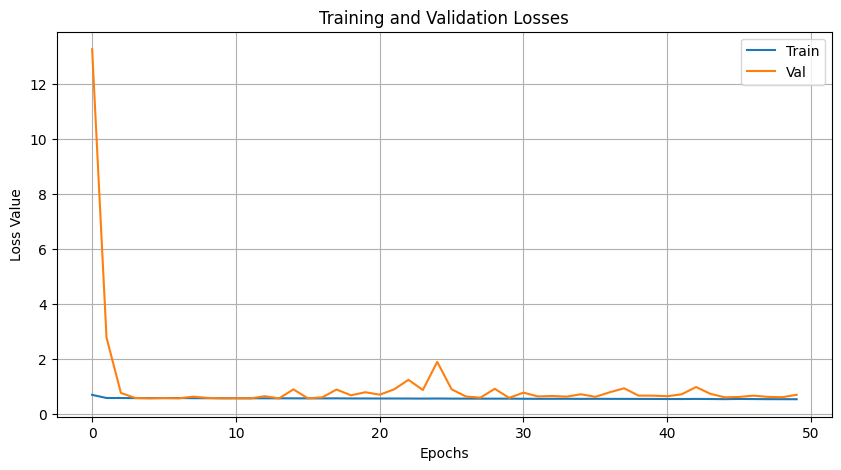

In [282]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_cnt, label='Train')
plt.plot(val_loss_cnt, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training and Validation Losses')
plt.grid(True)
plt.legend()
plt.show()
# plt.savefig('losses.png')

# 6] Multiresolution IsoSurface Extraction (MISE)

- Discretize the volumetric space at an initial resolution and evaluate the occupancy network fθ (p, x) for all p in this grid (corner points).

    1. We mark all grid points **p** as <font color="orange"> occupied </font> for which the occupancy is bigger or equal to some threshold τ. Next, we mark all voxels as <font color="forestgreen"> active </font> for which <font color="cornflowerblue">at least two adjacent grid points</font> have differing occupancy predictions. These are the voxels which would intersect the mesh with the marching cubes algorithm
    at the current resolution.
    2. We subdivide all <font color="cornflowerblue">active voxels into</font><font color="orange"> 8 </font> <font color="cornflowerblue">subvoxels</font> ($2x2x2$ grid) and evaluate all new grid points which are introduced to the occupancy grid through
    this subdivision.
    3. We repeat these steps until the desired final resolution is reached.
    
- At this final resolution, we apply the <font color="orangered">Marching Cubes algorithm</font> to extract an approximate isosurface : ${p ∈ R^3 | f_θ(p,x) = τ}$.

Our algorithm converges to the correct mesh if the occupancy grid at the initial resolution contains points from every connected component of both the
interior and the exterior of the mesh. It is hence important to take an initial resolution which is high enough to satisfy this condition.
In practice, we found that an initial resolution of $32^3$ was sufficient in almost all cases.
The initial mesh extracted by the Marching Cubes algorithm can be further refined. In a first step, we simplify the mesh using the
<font color="orangered">Fast-Quadric-Mesh-Simplification algorithm</font>. Finally, we refine the output mesh using first and second order (i.e., gradient) information.

In [227]:
class MISE():
    # Multiresolution IsoSurface Extraction
    def __init__(self, bmin=0.0, bmax=1.0, base_resolution=32, final_resolution=128):
        # these values defines the bounding box containing the cloud/mesh
        self.bmin = bmin
        self.bmax = bmax
        self.base_resolution = base_resolution
        self.final_resolution = final_resolution
        self.current_resolution = base_resolution
        self.threshold = 0.5

        self.occupancy = {} # store all occupancies that you have computed (i,j,k,resolution) where i,j,k are grid indices

    def grid2World(self, i, j, k, res):
        # grid idx (i,j,k) to coordinate (x,y,z) in bounding box
        step = (self.bmax-self.bmin)/(res-1)
        return (self.bmin + i*step, self.bmin + j*step, self.bmin + k*step)

    def world2grid(self, x,y,z, res):
        step = (self.bmax - self.bmin)/(res-1)
        return (int(round((x-self.bmin)/step)), int(round((y-self.bmin)/step)), int(round((z-self.bmin)/step)))

    def chunking(self, input, chunk_size=2048):
        # separate input (K,3) into (N,2048,3)
        output = []
        num_chunks = (input.shape[0]+chunk_size-1)//chunk_size
        for fake_batch in range(num_chunks):
            chunk = input[fake_batch*chunk_size:(fake_batch+1)*chunk_size]
            if chunk.shape[0] < chunk_size:
                chunk = np.concatenate((chunk, np.zeros((chunk_size-chunk.shape[0], chunk.shape[1]))), axis=0, dtype=np.float32)
            output.append(chunk)
        return np.stack(output)

    def EvaluateOccupancy(self, model, points):
        with torch.no_grad(): # assume to pass points before chunking
            chunks = self.chunking(points)
            print("Chunks: ", chunks.shape)
            occupancy = model.forward_MISE(torch.from_numpy(chunks).to(device)) # (k,chunk_size,1)
            occupancy = occupancy.cpu().numpy()
            occupancy = np.reshape(occupancy,(occupancy.shape[0]*occupancy.shape[1]*occupancy.shape[2]))
            return occupancy[:len(points)] # avoid saving occupancy for padding points

    def getCorners(self, grid_point):
        # needed to extract the corners from the voxel
        i, j, k = grid_point
        corners = [
            (i,   j,   k),
            (i+1, j,   k),
            (i,   j+1, k),
            (i,   j,   k+1),
            (i+1, j+1, k),
            (i+1, j,   k+1),
            (i,   j+1, k+1),
            (i+1, j+1, k+1),
        ]
        return corners

    def initGrid(self):
        grid = []
        for i in range(self.base_resolution):
            for j in range(self.base_resolution):
                for k in range(self.base_resolution):
                    grid.append(self.grid2World(i, j, k, self.base_resolution))
        # basically a grid of 3d points
        return np.array(grid, dtype=np.float32)

    def addOccupancy(self, grid_points, model):
        occupancies = self.EvaluateOccupancy(model, grid_points)
        for idx, (x, y, z) in enumerate(grid_points):
            i,j,k = self.world2grid(x, y, z, self.base_resolution)
            self.occupancy[(i, j, k, self.current_resolution)] = occupancies[idx]

    def ActiveCheck(self): # at least one occupied and one unoccupied corner
        active = []
        for i in range(self.current_resolution-1):
            for j in range(self.current_resolution-1):
                for k in range(self.current_resolution-1):
                    corners = self.getCorners((i,j,k))
                    skip_voxel = False
                    corner_vals = []
                    for (cx, cy, cz) in corners:
                        key = (cx, cy, cz, self.current_resolution)
                        if key not in self.occupancy:
                            skip_voxel = True
                            break
                        corner_vals.append(self.occupancy[key] >= self.threshold)
                    if skip_voxel: # corner does not exist
                        continue
                    if any(corner_vals) and not all(corner_vals): # one occupied and one not
                        active.append((i,j,k))
        return np.array(active, dtype=np.int32)

    def divideActiveVoxels(self, active_voxels): # each active voxels shoul be divided into 8 subvoxels (2x2x2 grid)
        old_res = self.current_resolution
        new_res = 2 * old_res
        if new_res > self.final_resolution: # out of resolution check
            new_res = self.final_resolution
        self.current_resolution = new_res

        # sample only inside or near active voxels
        new_grid_points = []
        for (i,j,k) in active_voxels:
            for di in (0,1):
                for dj in (0,1):
                    for dk in (0,1):
                        new_i = 2*i + di
                        new_j = 2*j + dj
                        new_k = 2*k + dk
                        if (new_i, new_j, new_k, self.current_resolution) not in self.occupancy:
                            new_grid_points.append(self.grid2World(new_i, new_j, new_k, self.current_resolution))

        return np.asarray(new_grid_points, dtype=np.float32)

    def plotGrid(self, res):
        x_occ, y_occ, z_occ = [], [], []
        xs, ys, zs = [], [], []

        for i in range(res):
            for j in range(res):
                for k in range(res):
                    if (i, j, k, res) in self.occupancy:
                        x, y, z = self.grid2World(i, j, k, res)
                        if self.occupancy[(i, j, k, res)] >= self.threshold:
                            x_occ.append(x)
                            y_occ.append(y)
                            z_occ.append(z)
                        else :
                            x, y, z = self.grid2World(i, j, k, res)
                            xs.append(x)
                            ys.append(y)
                            zs.append(z)


        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_occ, y_occ, z_occ, s=1, c='red', label="occupied")
        ax.scatter(xs, ys, zs, s=1, c='cornflowerblue', label="not occupied")
        ax.set_title(f"Resolution = {res}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.show()

    def getMesh(self):
        resol = self.current_resolution
        volume = np.zeros((resol,resol,resol), dtype=np.float32)
        for (i,j,k,r) in self.occupancy:
            if r==resol:
                volume[i,j,k] = self.occupancy[(i,j,k,r)]

        verts, faces, normals, values = measure.marching_cubes(volume)
        # worl2grid
        step = (self.bmax - self.bmin)/(resol-1)
        verts_world = np.zeros_like(verts)
        verts_world[:,0] = self.bmin + verts[:,0]* step
        verts_world[:,1] = self.bmin + verts[:,1]* step
        verts_world[:,2] = self.bmin + verts[:,2]* step

        mesh_tri = trimesh.Trimesh(vertices=verts_world, faces=faces)
        print("The mesh is watertight? ", mesh_tri.is_watertight)
        mesh_o3d = o3d.geometry.TriangleMesh()
        mesh_o3d.vertices = o3d.utility.Vector3dVector(verts_world)
        mesh_o3d.triangles = o3d.utility.Vector3iVector(faces)
        return mesh_tri, mesh_o3d

    def run(self, model, noisy_cloud):
        model.getEncoderFeatures(noisy_cloud) # compute once features + plane params
        # not handling batches right now
        grid = self.initGrid()
        print(f"Grid correctly initialized: {grid.shape}")
        self.addOccupancy(grid, model)
        # print(len(self.occupancy.keys()))
        self.plotGrid(self.base_resolution)
        iter = 0
        while self.current_resolution < self.final_resolution:
            print(f"Increase resolution step number {iter}")
            active_voxels = self.ActiveCheck()
            if len(active_voxels) <= 0:
                print("Active voxels not found")
                return None
            print(f"Active voxel num: {len(active_voxels)}")
            new_grid = self.divideActiveVoxels(active_voxels)
            print(f"New grid: {new_grid.shape}, {new_grid.dtype}")
            self.addOccupancy(new_grid, model)
            iter += 1

            self.plotGrid(self.current_resolution)

        _, mesh_o3d = self.getMesh()
        o3d.visualization.draw_plotly([mesh_o3d])

        return mesh_o3d

Grid correctly initialized: (32768, 3)
Chunks:  (16, 2048, 3)


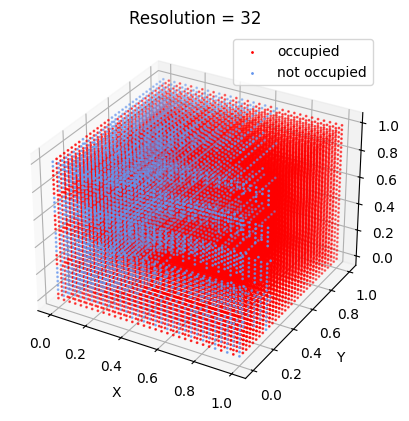

Increase resolution step number 0
Active voxel num: 12047
New grid: (96376, 3), float32
Chunks:  (48, 2048, 3)


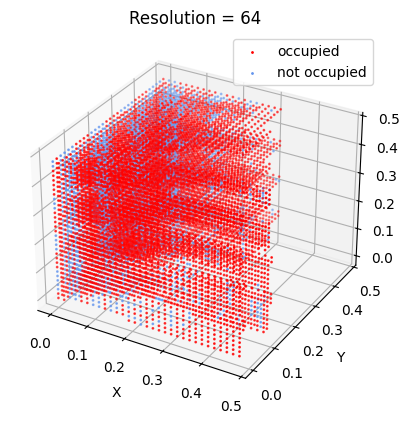

Increase resolution step number 1
Active voxel num: 5743
New grid: (45944, 3), float32
Chunks:  (23, 2048, 3)


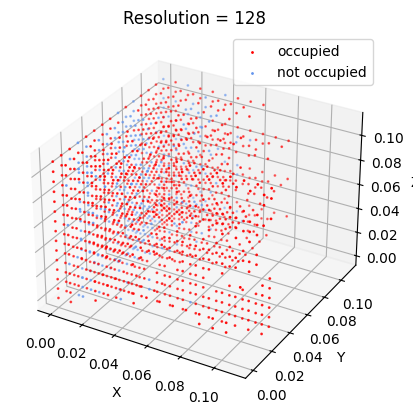

The mesh is watertight?  False


In [245]:
completeModel = CompleteArchitecture().to(device)
mise = MISE()
for batch in val_loader:
    scan, registration, sampled_cloud, scan_list, reg_list, labels = batch
    noisy_cloud = addNoise(scan)
    completeModel.eval()
    with torch.no_grad():
        mise.run(completeModel, noisy_cloud)
        break

# 7] Evaluation